In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from re import search
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [2]:
# Save current path
path = os.getcwd()

In [3]:
# Lists for saving MRI images and corresponding label
images_no = []
images_yes = []
label = []

# Import images
for folders in os.listdir(path):
    if((folders == "no") or (folders == "no_tumor")):
        for files in os.listdir(folders):
            if search("Thumbs.db", files):
                del(files)
            else:
                # Open images and convert to RGB
                current_image = Image.open(folders + "\\" + files).convert('RGB')
                images_no.append(current_image)
                # Save label 0 for no tumor
                label.append(0)
    if((folders == "yes") or (folders == "glioma_tumor") or (folders == "meningioma_tumor") or (folders == "pituitary_tumor")):
        for files in os.listdir(folders):
            if search("Thumbs.db", files):
                del(files)
            else:
                # Open images and convert to RGB
                current_image = Image.open(folders + "\\" + files).convert('RGB')
                images_yes.append(current_image)
                # Save label 1 for tumor
                label.append(1)

In [4]:
# Function to plot 20 images in a subplot
def plot_mri(images, title, test_label, predicted_label):
    # Plot first 20 MRI without brain tumor in a subplot
    fig, axs = plt.subplots(5, 4, figsize=(18,18))
    fig.suptitle(title, fontsize=30)
    axs = axs.ravel()
    for elem in range(20):
        axs[elem].imshow(images[elem], cmap = "Greys")
        # If predicted label is existent then a subtitle is added
        if((test_label != "") or (predicted_label != "")):
            subplot_titel = "Real label: " + str(test_label[elem]) + ", Predicted label: " + str(predicted_label[elem].numpy())
            axs[elem].set_title(subplot_titel, fontsize=8)
    plt.show()

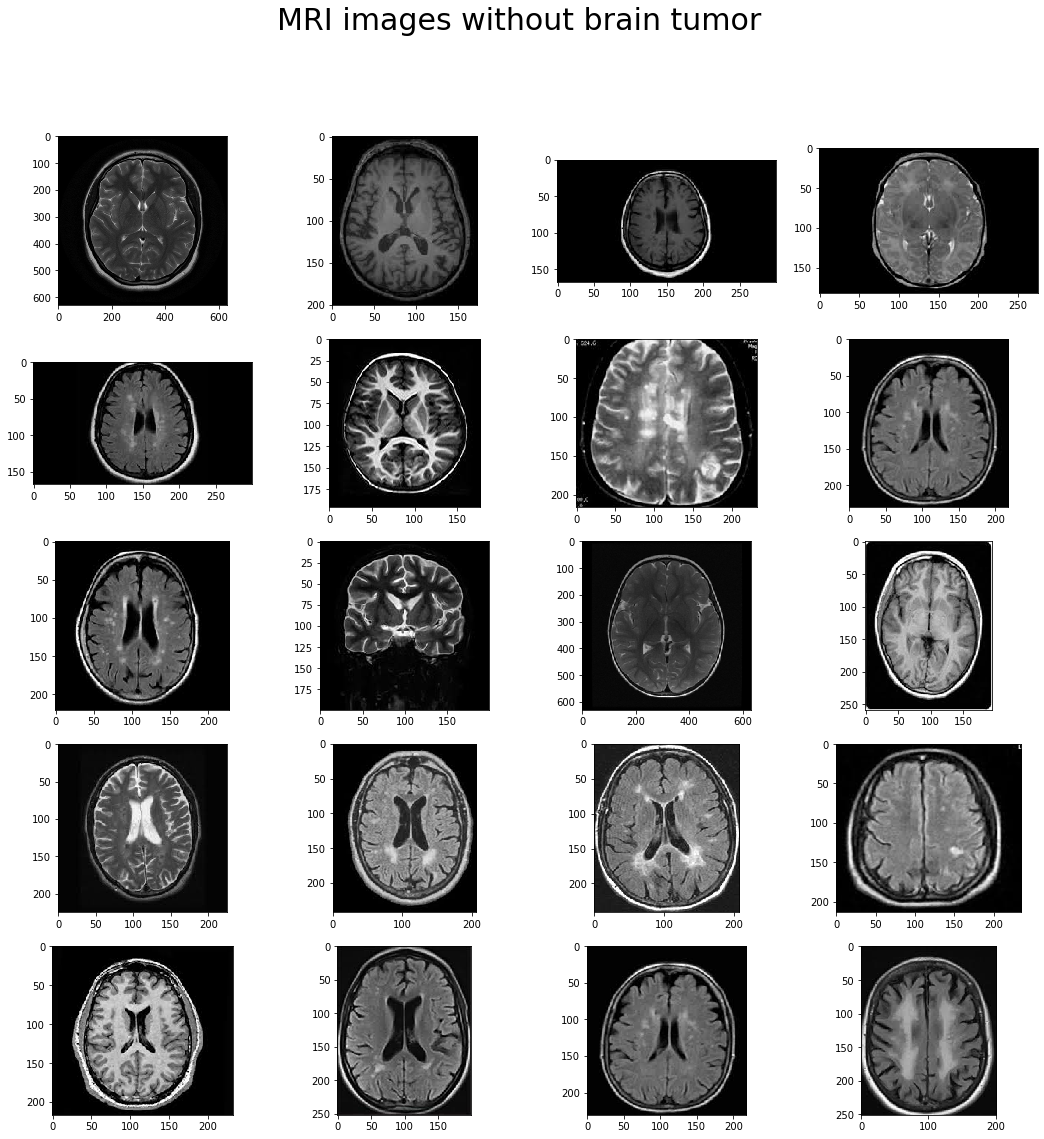

In [5]:
# Plot first 20 MRI images without brain tumor
plot_mri(images_no, 'MRI images without brain tumor', "", "")

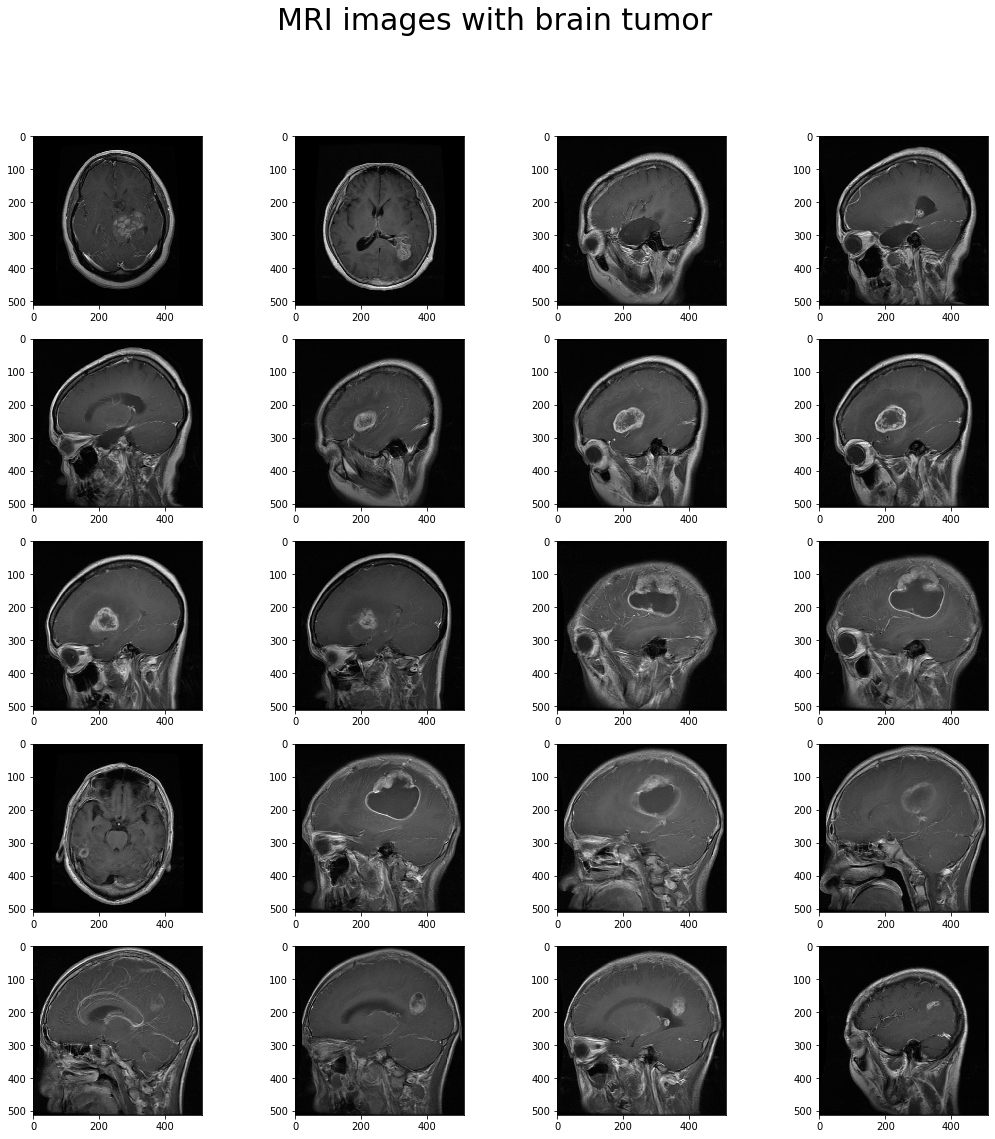

In [6]:
# Plot first 20 MRI images with brain tumor
plot_mri(images_yes, 'MRI images with brain tumor', "", "")

In [7]:
# Function to crop images 
def trim(image):
    # Get the bounding box of the non-zero regions in the current image
    box = image.getbbox()
    if box:
        # Crop the image using the bounding box
        return image.crop(box)

In [8]:
# Crop all images
images_no_crop = []
images_yes_crop = []
for i in range(len(images_no)):
    images_no_crop.append(trim(images_no[i]))
for j in range(len(images_yes)):
    images_yes_crop.append(trim(images_yes[j]))

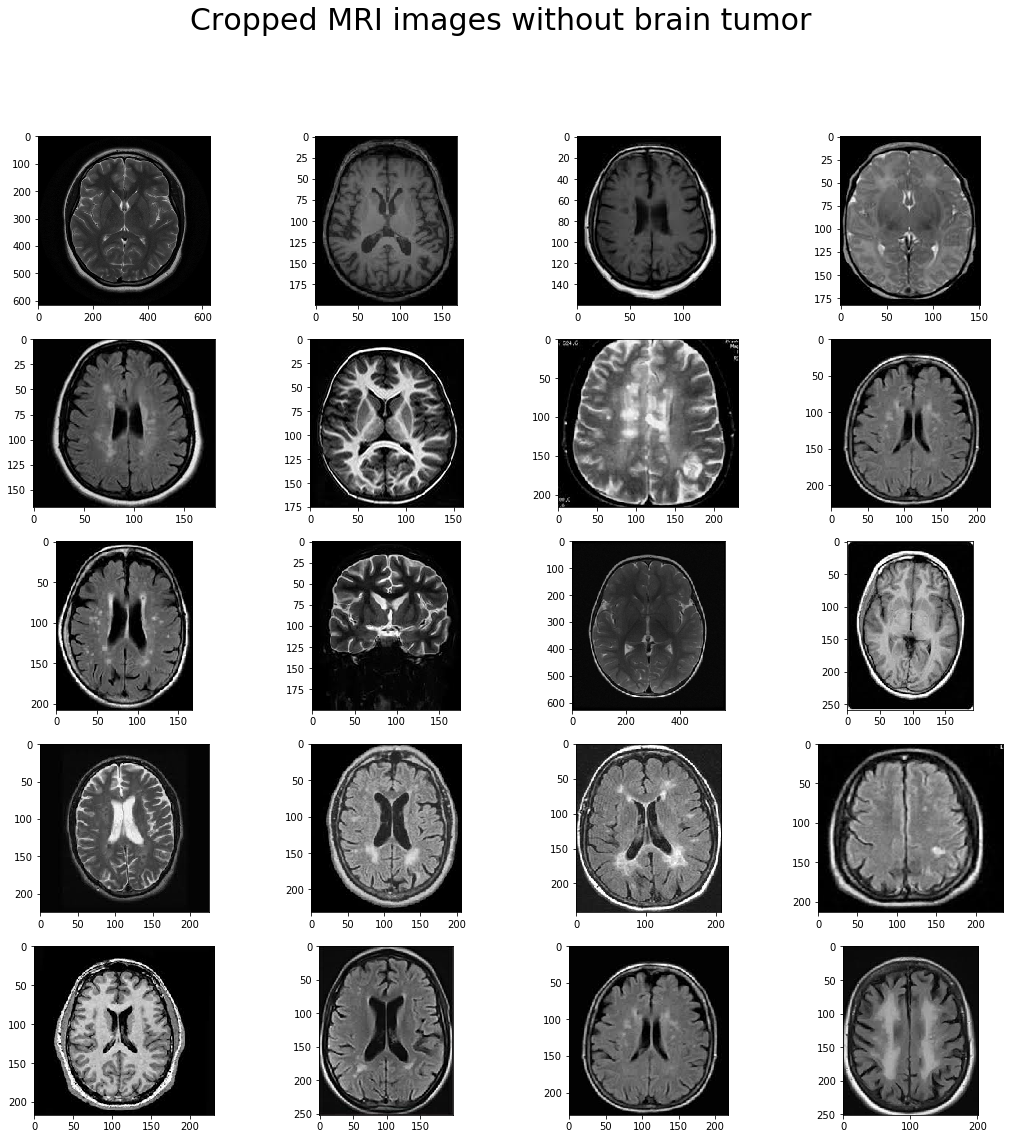

In [9]:
# Plot first 20 cropped MRI images without brain tumor
plot_mri(images_no_crop, 'Cropped MRI images without brain tumor', "", "")

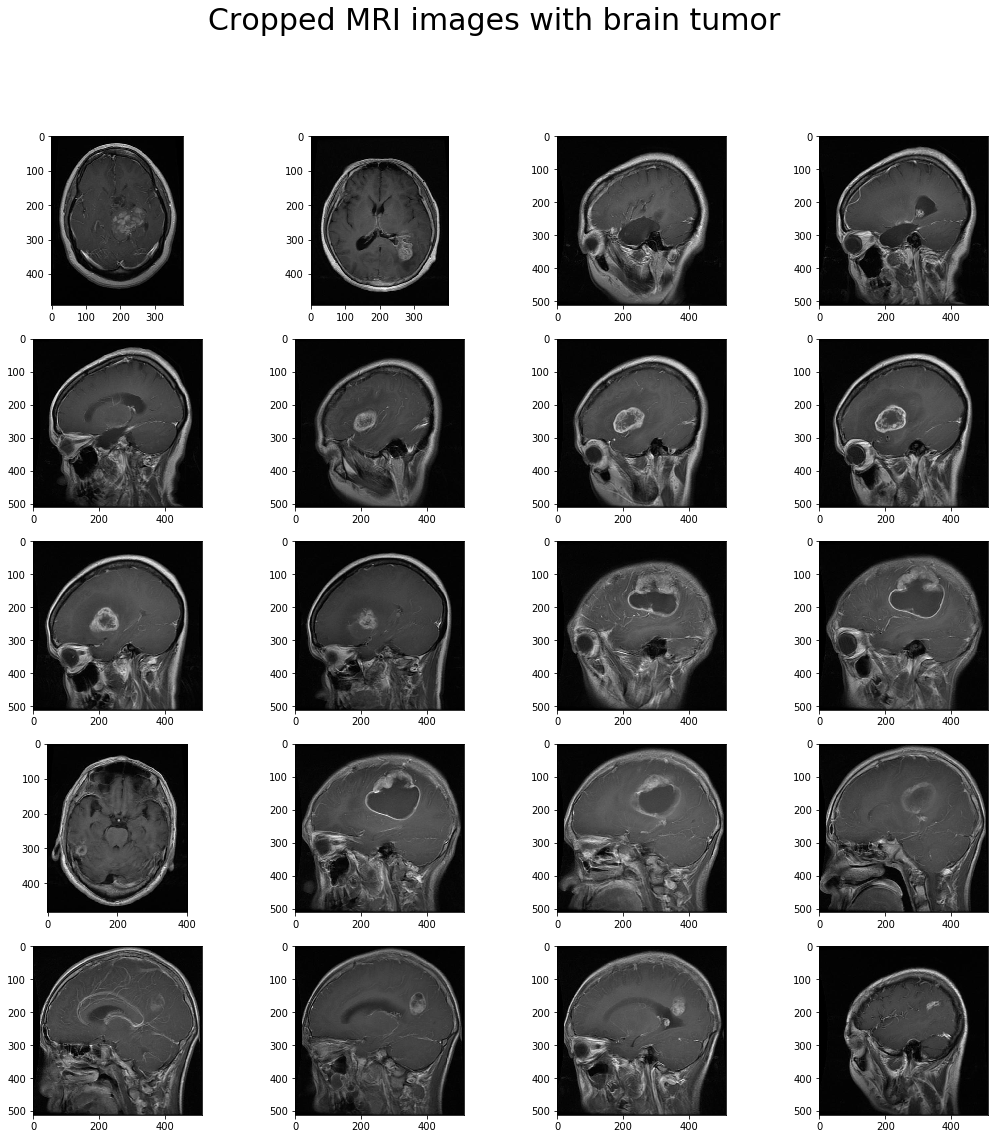

In [10]:
# Plot first 20 cropped MRI images with brain tumor
plot_mri(images_yes_crop, 'Cropped MRI images with brain tumor', "", "")

In [11]:
# Resize all images to (250,250)
images_no_resize = []
images_yes_resize = []
for k in range(len(images_no_crop)):
    images_no_resize.append(images_no_crop[k].resize((250,250)))
for l in range(len(images_yes_crop)):
    images_yes_resize.append(images_yes_crop[l].resize((250,250)))

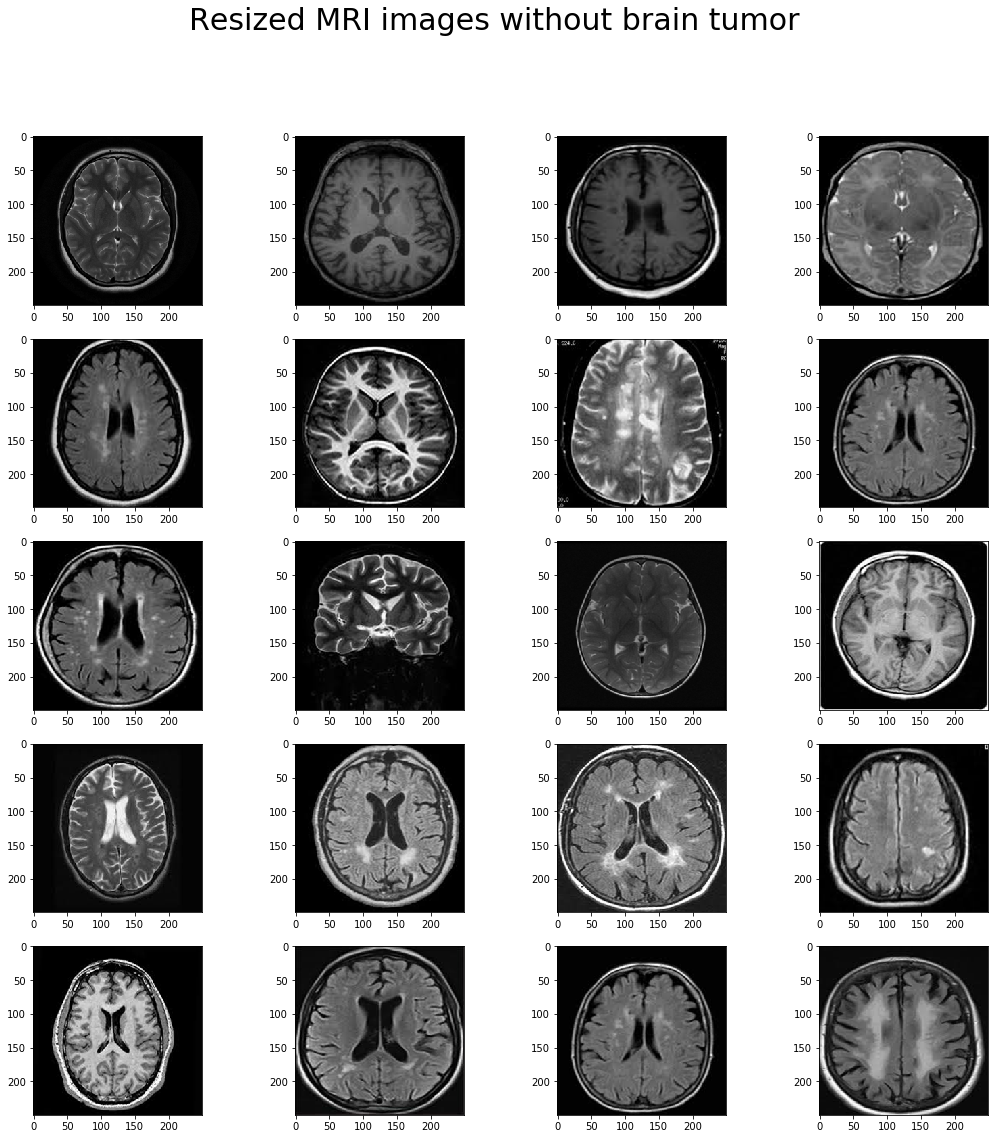

In [12]:
# Plot first 20 resized MRI images without brain tumor
plot_mri(images_no_resize, 'Resized MRI images without brain tumor', "", "")

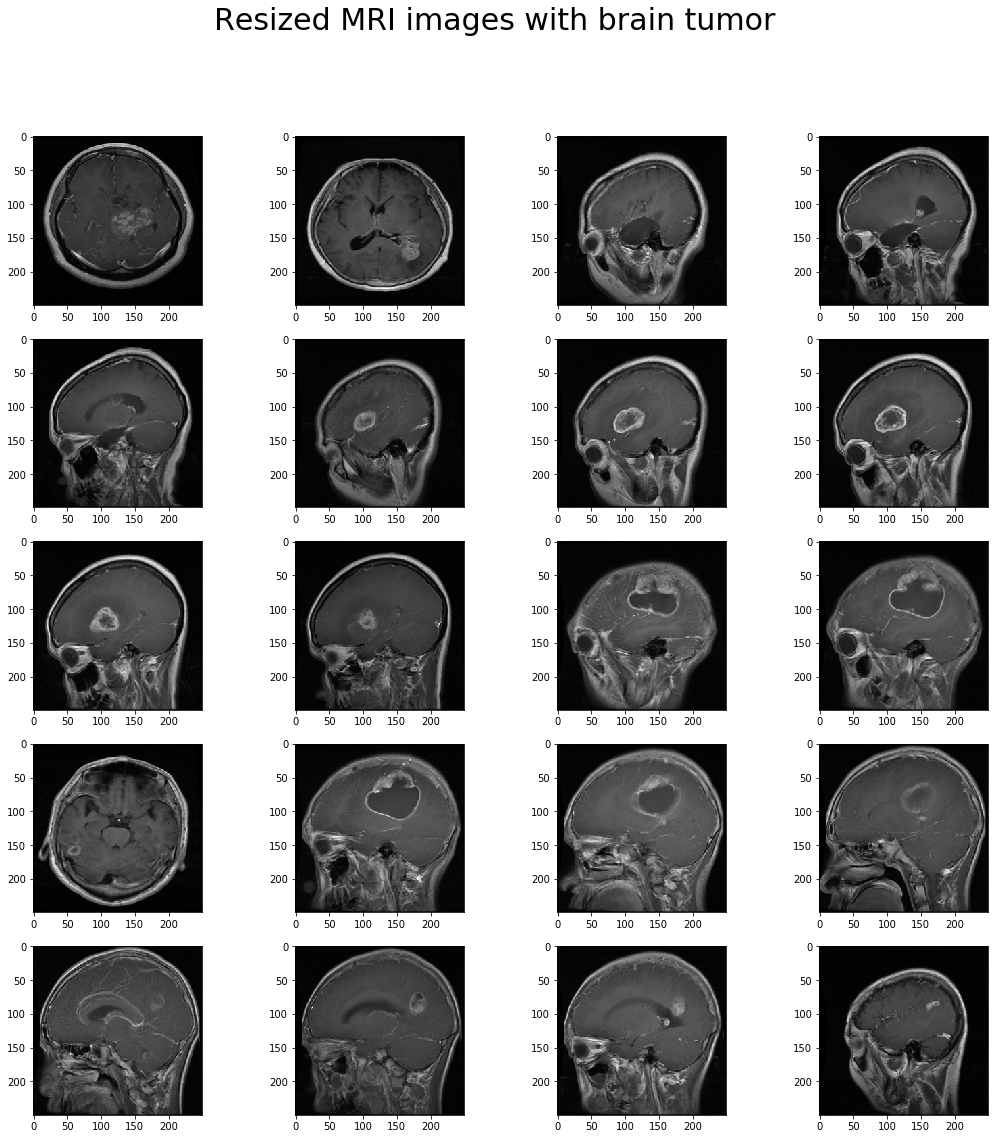

In [13]:
# Plot first 20 resized MRI images with brain tumor
plot_mri(images_yes_resize, 'Resized MRI images with brain tumor', "", "")

In [14]:
# Convert each image to numpy array and normalize the data
images = []

for m in range(len(images_no_resize)):
    images.append(np.array(images_no_resize[m])/255)
for n in range(len(images_yes_resize)):
    images.append(np.array(images_yes_resize[n])/255)

In [15]:
# Save label as numpy array
label = np.array(label)

In [16]:
# Divide dataset in train data and test data
train_images, test_images, train_label, test_label = train_test_split(images, label, test_size=0.30, random_state=42)

print("Number of train images: ", len(train_images))
print("Number of test images:", len(test_images))

Number of train images:  2461
Number of test images: 1056


In [17]:
# Define numpy array for softmax output
train_label_softmax = np.zeros(shape=(len(train_label),2), dtype=np.float32)
test_label_softmax = np.zeros(shape=(len(test_label),2), dtype=np.float32)

# Set index of numpy array corresponding to current label to 1
for p in range(2):
    train_label_softmax[np.where(train_label == p), p] = 1
    test_label_softmax[np.where(test_label == p), p] = 1    

In [18]:
# Convert train data and test data to tensor
train_images = tf.convert_to_tensor(train_images)
test_images = tf.convert_to_tensor(test_images)

In [19]:
# Convert label to tensor
train_label_softmax = tf.convert_to_tensor(train_label_softmax)
test_label_softmax = tf.convert_to_tensor(test_label_softmax)

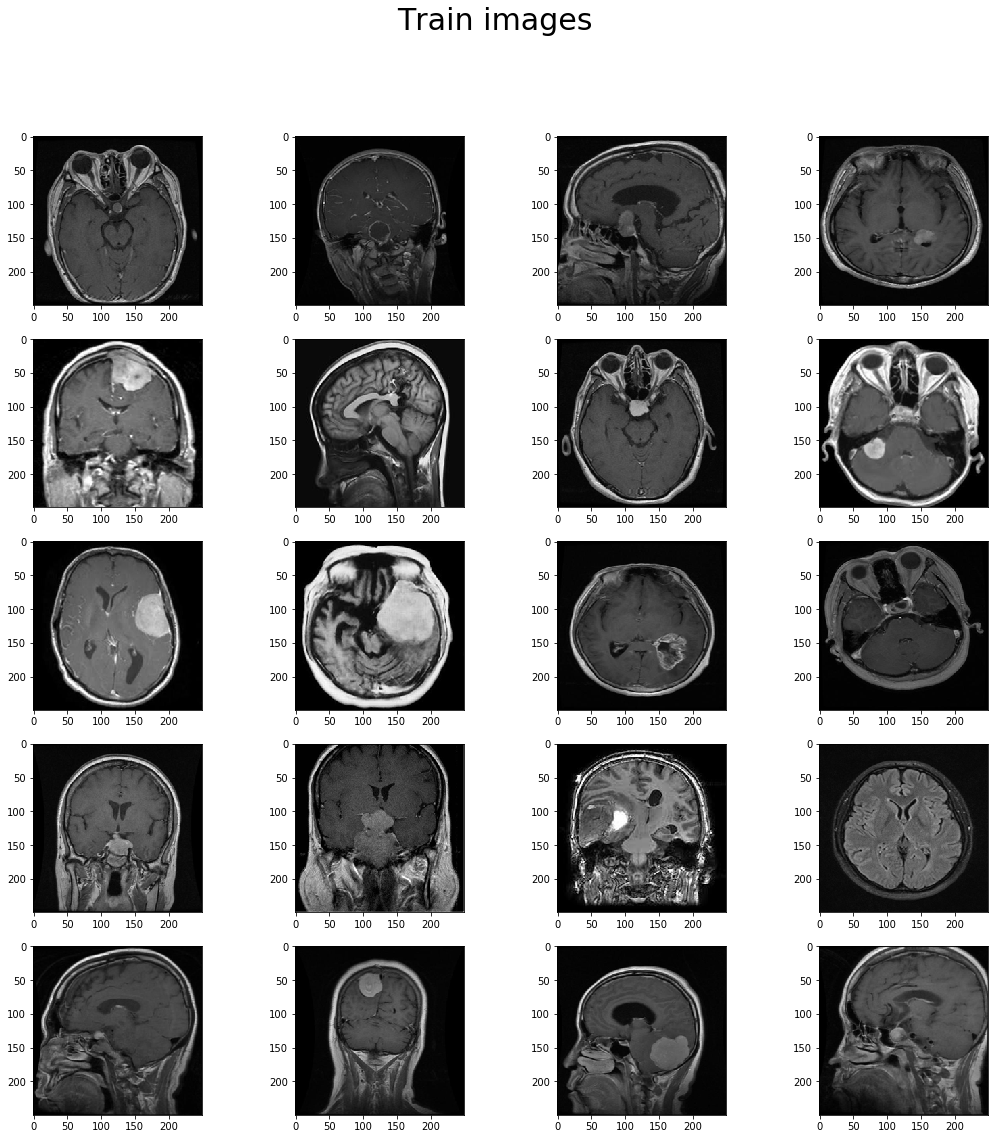

In [20]:
# Plot first 20 train MRI images
plot_mri(train_images, 'Train images', "", "")

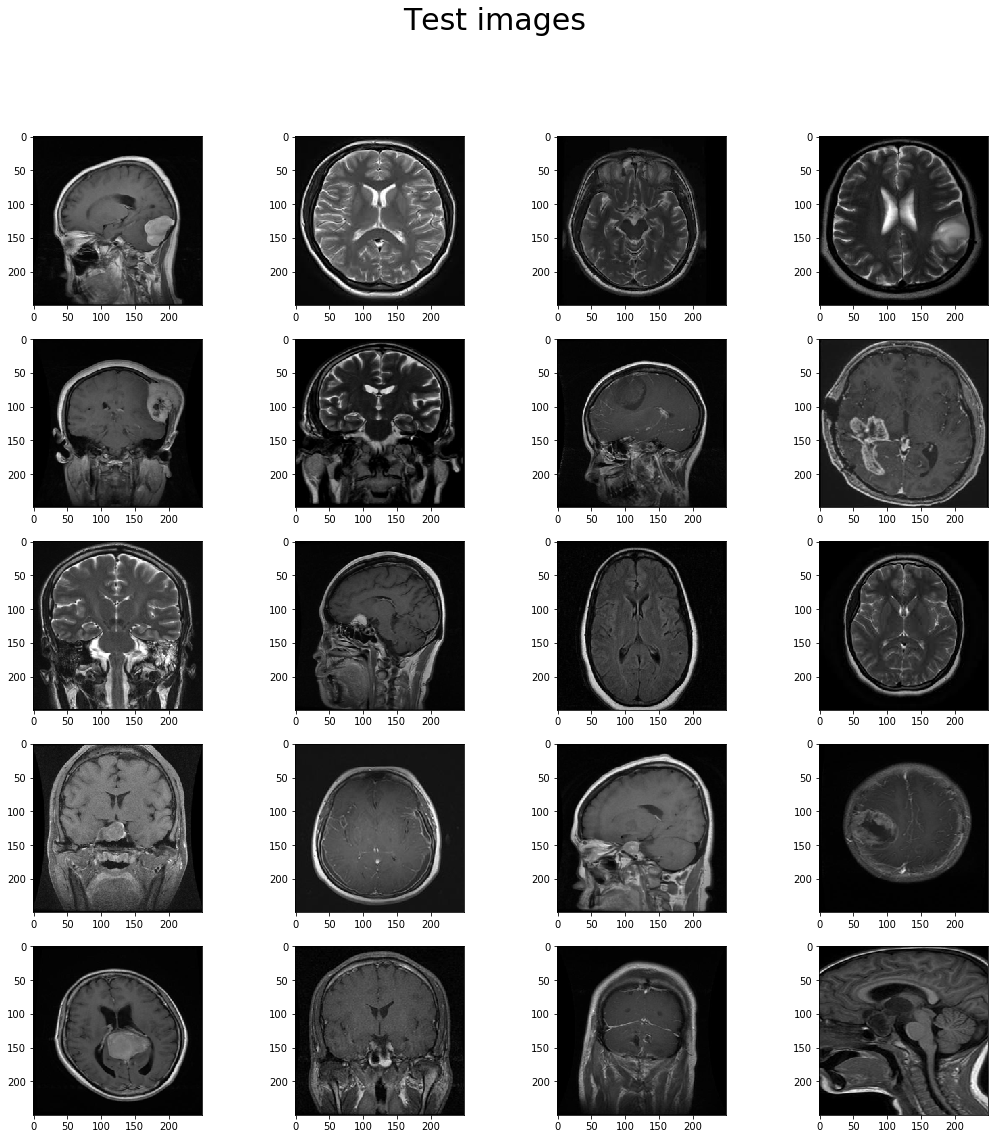

In [21]:
# Plot first 20 test MRI images
plot_mri(test_images, 'Test images', "", "")

In [22]:
# Modify convolutional neuronal network model
model = tf.keras.Sequential([
    tf.keras.layers.ZeroPadding2D(padding=(5,5), input_shape=(250,250,3)),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(10,10), strides=(1,1), activation="relu"),
    tf.keras.layers.MaxPooling2D((5,5)),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(10,10), strides=(1,1), activation="relu"),
    tf.keras.layers.MaxPooling2D((5,5)),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2, activation = "relu"),
    tf.keras.layers.Dense(2, activation = "softmax")
    ])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 260, 260, 3)       0         
_________________________________________________________________
dropout (Dropout)            (None, 260, 260, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 251, 251, 32)      9632      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 41, 41, 64)        204864    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0

In [23]:
# Define the loss function and the minimizer
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [24]:
# Fit the model
model.fit(train_images, train_label_softmax, epochs=5, batch_size = 30)

Train on 2461 samples
Epoch 1/5
2461/2461 [==============================] - 451s 183ms/sample - loss: 0.4897 - accuracy: 0.8070
Epoch 2/5
2461/2461 [==============================] - 427s 173ms/sample - loss: 0.4567 - accuracy: 0.8163
Epoch 3/5
2461/2461 [==============================] - 461s 187ms/sample - loss: 0.4457 - accuracy: 0.8163
Epoch 4/5
2461/2461 [==============================] - 442s 180ms/sample - loss: 0.4196 - accuracy: 0.8163
Epoch 5/5
2461/2461 [==============================] - 441s 179ms/sample - loss: 0.4003 - accuracy: 0.8163


In [25]:
# Evaluation on test data
results = model.evaluate(test_images, test_label_softmax, batch_size=30)
print("Test loss: ", results[0])
print("Test accuracy: ", results[1])

1056/1056 [==============================] - 62s 59ms/sample - loss: 0.3303 - accuracy: 0.8617
Test loss:  0.33031396398490126
Test accuracy:  0.86174244


In [26]:
# Predict result of test data
predictions = model.predict(test_images)

# Calculate number of correct predicted images
correct_predicted = tf.reduce_sum(tf.cast(tf.argmax(predictions ,axis=1)==test_label ,tf.int16)).numpy()
print("Correct predicted test images: ", correct_predicted, " out of ", len(test_label))

Correct predicted test images:  910  out of  1056


C:\Users\Martina\anaconda3\envs\tensor\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  # Remove the CWD from sys.path while we load stuff.


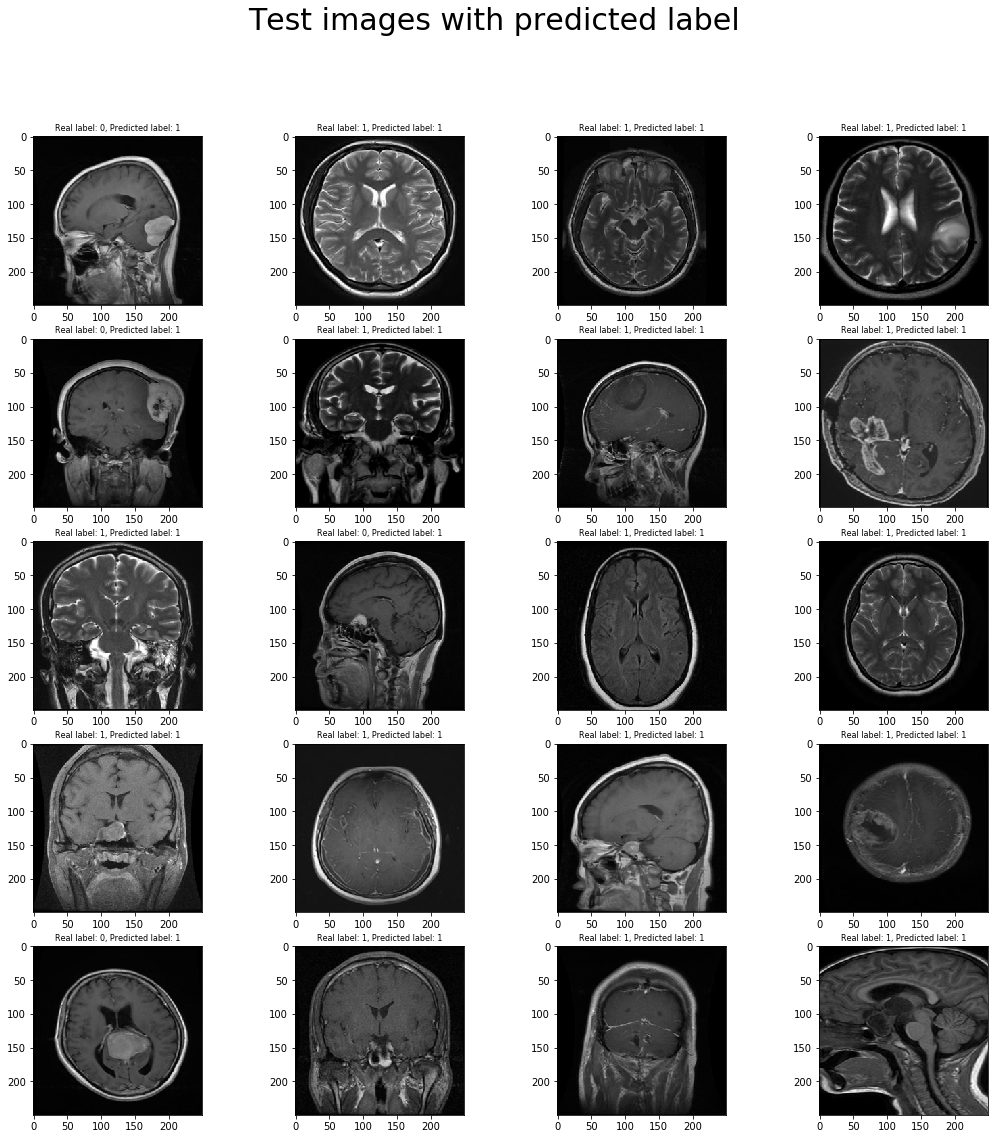

In [27]:
# Plot test images with predicted label
predicted_label = (tf.argmax(predictions, axis=1))
plot_mri(test_images, 'Test images with predicted label', test_label, predicted_label)